## K - Nearest Neighbors Classifier

Columns in dataset:
 ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_%3B', 'char_freq_%28', 'char_freq_%5B', 'char_freq_%21', 'char_fr

C:\Users\Kavi\AppData\Local\Temp\ipykernel_5912\1660368636.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


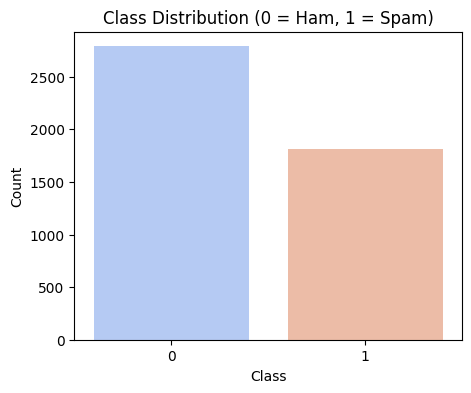

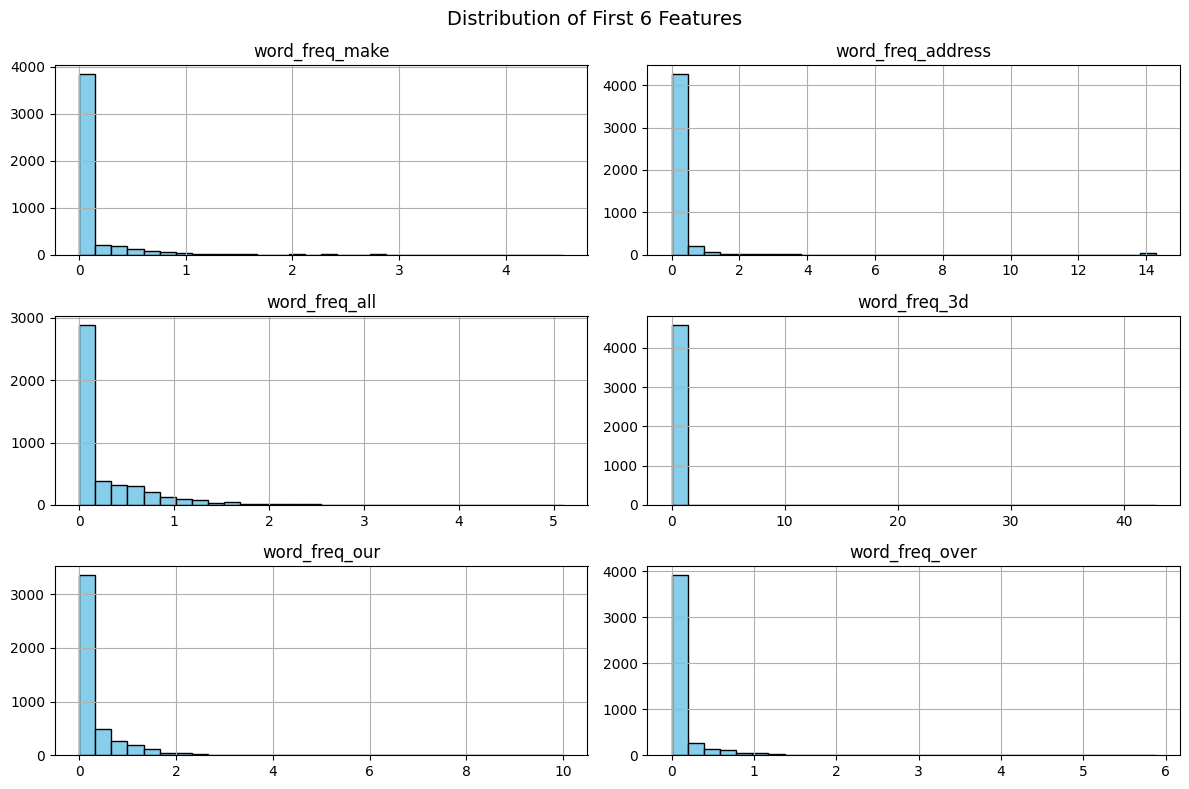

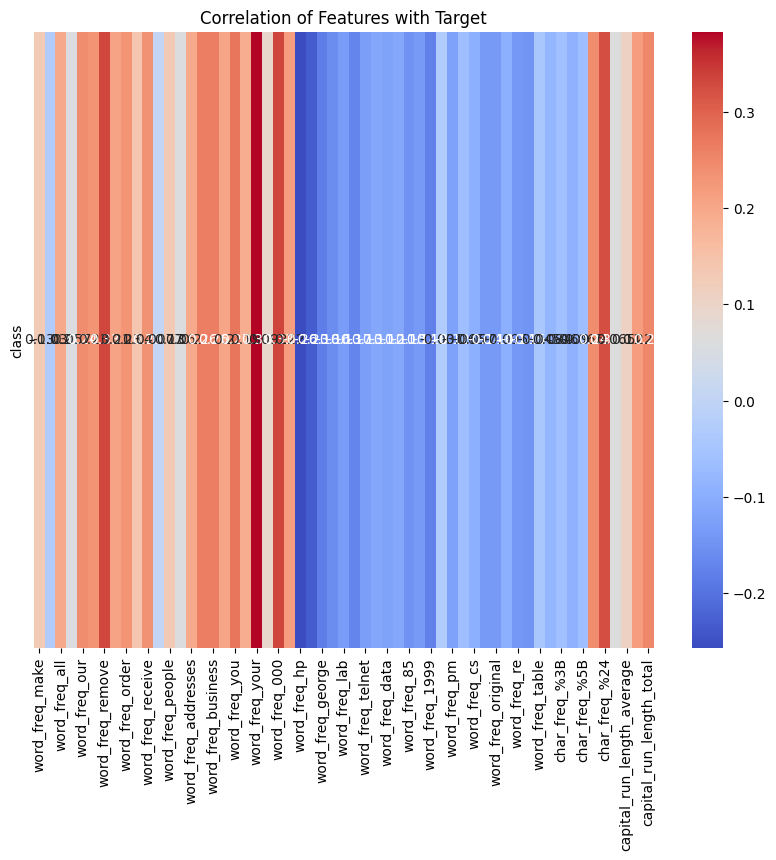

In [7]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.utils import parallel_backend
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, roc_curve,
                             confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score)

# 1. Load Dataset
df = pd.read_csv('C:/Users/KAVI/Downloads/spambase_csv.csv')
print("Columns in dataset:\n", df.columns.tolist())
print("Dataset shape:", df.shape)

# 2. Separate features and target, last column is the target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]


# 4. EDA
plt.figure(figsize=(5,4))
sns.countplot(x=y, palette="coolwarm")
plt.title("Class Distribution (0 = Ham, 1 = Spam)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Histograms of first 6 features
X.iloc[:, :6].hist(bins=30, figsize=(12, 8), color='skyblue', edgecolor='black')
plt.suptitle("Distribution of First 6 Features", fontsize=14)
plt.tight_layout()
plt.show()

# Correlation heatmap (optional, heavy if many features)
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr.iloc[-1:,:-1], annot=True, cmap="coolwarm")
plt.title("Correlation of Features with Target")
plt.show()

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [8]:
# Predict & Performance Analysis
def test_model(best_estimator, X_test,y_test):
    y_pred = best_estimator.predict(X_test)
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    return performance_metrics(y_test, y_pred, y_proba)

# Performance metrics
def performance_metrics(y_true, y_pred, y_proba):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_precision = average_precision_score(y_test, y_proba)

    print("\nTest metrics")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Avg Precision (PR AUC-ish): {avg_precision:.4f}")
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # 7. Curves: ROC & Precision-Recall
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
    plt.plot([0,1],[0,1],'--', alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend(); plt.show()

# Define multiple metrics
def kfoldCV(best_estimator, X, y, cv):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    # Run cross-validation
    with parallel_backend('threading'):
        cv_results = cross_validate(
            best_estimator, X, y, cv=cv,
            scoring=scoring,
            return_train_score=False,
            n_jobs=-1
        )

    n_splits = cv.get_n_splits()
    # Display per-fold results
    for i in range(n_splits):
        print(f"\nFold {i+1}: Accuracy: {cv_results['test_accuracy'][i]:.4f}   Precision: {cv_results['test_precision'][i]:.4f}   Recall: {cv_results['test_recall'][i]:.4f}   F1 Score: {cv_results['test_f1'][i]:.4f}")

    # Display averages
    print("\n=== Average Metrics ===")
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
    print(f"Mean Precision: {cv_results['test_precision'].mean():.4f} ± {cv_results['test_precision'].std():.4f}")
    print(f"Mean Recall:    {cv_results['test_recall'].mean():.4f} ± {cv_results['test_recall'].std():.4f}")
    print(f"Mean F1 Score:  {cv_results['test_f1'].mean():.4f} ± {cv_results['test_f1'].std():.4f}")

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid_knn = {
    'clf__n_neighbors': list(range(1, 21, 2)),   # vary K
    'clf__weights': ['uniform', 'distance'], # weighting strategy
    'clf__p': [1, 2]                         # distance metric
}

# Function to run pipeline + gridsearch
def run_knn_pipeline(algorithm_name):
    print(f"\n===== Running KNN with {algorithm_name.upper()} =====")
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', KNeighborsClassifier(algorithm=algorithm_name))
    ])
    
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_knn,
        cv=cv,
        scoring={'AUC': 'roc_auc', 'F1': 'f1'},
        refit='AUC',
        n_jobs=-1,
        verbose=2
    )
    
    # Track time
    start_time = time.time()
    with parallel_backend('threading'):
        grid.fit(X_train, y_train)
    end_time = time.time()
    elapsed = end_time - start_time
    
    best = grid.best_estimator_
    print("Best parameters:", grid.best_params_)
    print("Best cross-validated AUC:", grid.best_score_)
    print(f"Time taken: {elapsed:.2f} seconds")
    
    # Evaluate
    test_model(best, X_test, y_test)
    kfoldCV(best, X, y, cv)
    
    return best, elapsed



===== Running KNN with BRUTE =====
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.4s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.4s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.4s
[CV] END clf__n_neighbors=1, clf__p=2, clf__weights=distance; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=1

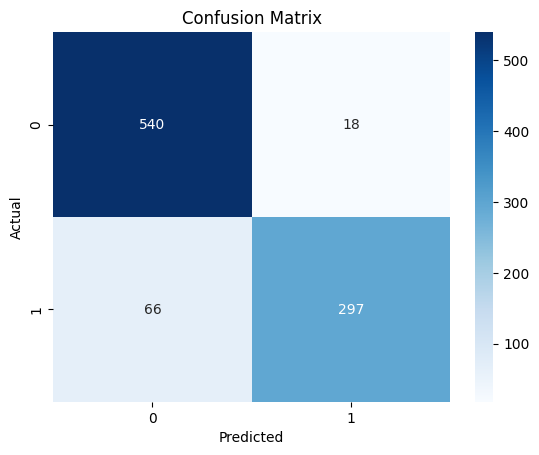

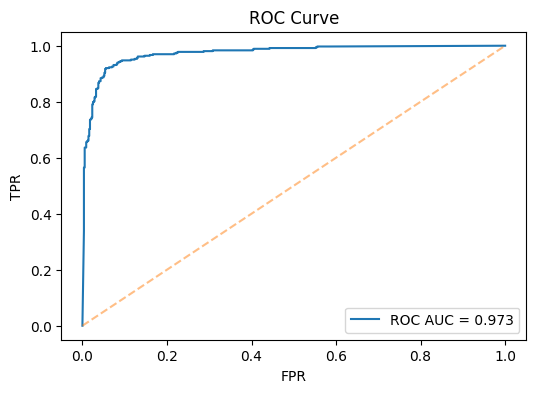


Fold 1: Accuracy: 0.9164   Precision: 0.9441   Recall: 0.8375   F1 Score: 0.8876

Fold 2: Accuracy: 0.9261   Precision: 0.9567   Recall: 0.8512   F1 Score: 0.9009

Fold 3: Accuracy: 0.9261   Precision: 0.9511   Recall: 0.8567   F1 Score: 0.9014

Fold 4: Accuracy: 0.9207   Precision: 0.9646   Recall: 0.8287   F1 Score: 0.8915

Fold 5: Accuracy: 0.9207   Precision: 0.9707   Recall: 0.8232   F1 Score: 0.8909

=== Average Metrics ===
Mean Accuracy: 0.9220 ± 0.0037
Mean Precision: 0.9574 ± 0.0094
Mean Recall:    0.8395 ± 0.0128
Mean F1 Score:  0.8945 ± 0.0056
Brute: 6.77 sec


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
# Vary K
best_brute, time_brute = run_knn_pipeline("brute")
print(f"Brute: {time_brute:.2f} sec")

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)



===== Running KNN with KD_TREE =====
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.5s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.8s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.8s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.8s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.8s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.8s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.8s
[CV] END 

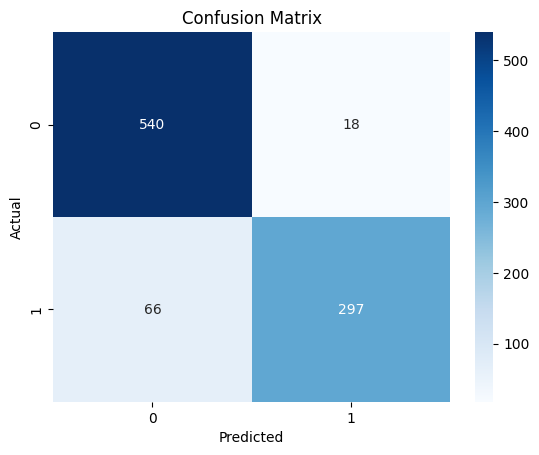

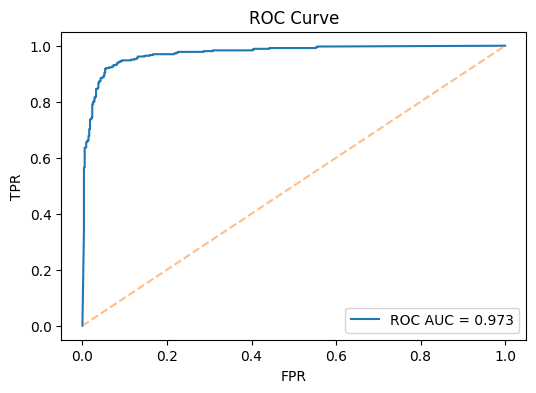

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)



Fold 1: Accuracy: 0.9164   Precision: 0.9441   Recall: 0.8375   F1 Score: 0.8876

Fold 2: Accuracy: 0.9261   Precision: 0.9567   Recall: 0.8512   F1 Score: 0.9009

Fold 3: Accuracy: 0.9261   Precision: 0.9511   Recall: 0.8567   F1 Score: 0.9014

Fold 4: Accuracy: 0.9207   Precision: 0.9646   Recall: 0.8287   F1 Score: 0.8915

Fold 5: Accuracy: 0.9207   Precision: 0.9707   Recall: 0.8232   F1 Score: 0.8909

=== Average Metrics ===
Mean Accuracy: 0.9220 ± 0.0037
Mean Precision: 0.9574 ± 0.0094
Mean Recall:    0.8395 ± 0.0128
Mean F1 Score:  0.8945 ± 0.0056
KDTree: 9.58 sec


In [11]:
# KDTree
best_kd, time_kd = run_knn_pipeline("kd_tree")
print(f"KDTree: {time_kd:.2f} sec")


===== Running KNN with BALL_TREE =====
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)


[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.4s
[CV] END clf__n_neighbors=1, clf__p=2, clf__weights=distance; total time=   0.4s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=1, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.7s
[CV] END .clf__n_neighbors=1, clf__p=2, clf__weights=uniform; total time=   0.7s
[CV] END .clf__n_neighbors=1, clf__p=1, clf__weights=uniform; total time=   0.7s
[CV] END .clf__n_neighbors=1

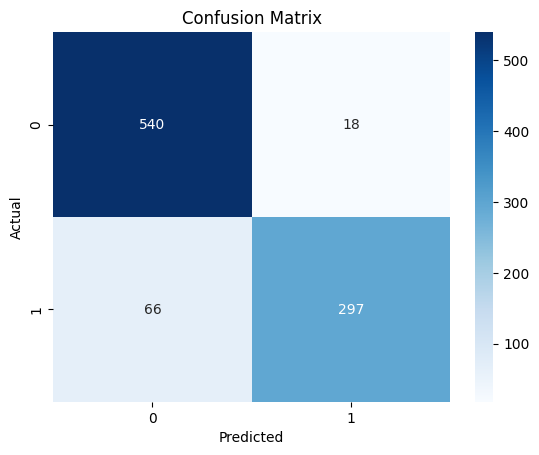

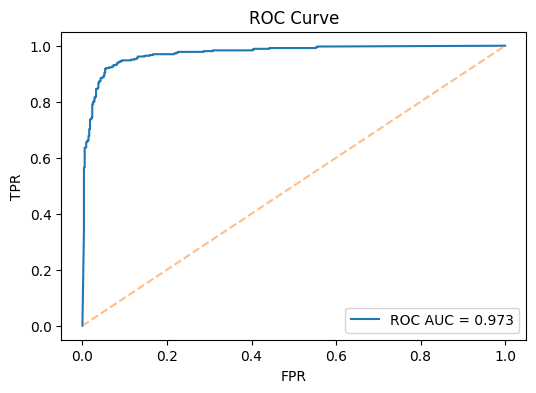

C:\Users\Kavi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\deprecation.py:71: FutureWarning: Class parallel_backend is deprecated; deprecated in 1.5 to be removed in 1.7. Use joblib.{} instead.
  warnings.warn(msg, category=FutureWarning)



Fold 1: Accuracy: 0.9164   Precision: 0.9441   Recall: 0.8375   F1 Score: 0.8876

Fold 2: Accuracy: 0.9261   Precision: 0.9567   Recall: 0.8512   F1 Score: 0.9009

Fold 3: Accuracy: 0.9261   Precision: 0.9511   Recall: 0.8567   F1 Score: 0.9014

Fold 4: Accuracy: 0.9207   Precision: 0.9646   Recall: 0.8287   F1 Score: 0.8915

Fold 5: Accuracy: 0.9207   Precision: 0.9707   Recall: 0.8232   F1 Score: 0.8909

=== Average Metrics ===
Mean Accuracy: 0.9220 ± 0.0037
Mean Precision: 0.9574 ± 0.0094
Mean Recall:    0.8395 ± 0.0128
Mean F1 Score:  0.8945 ± 0.0056
BallTree: 7.99 sec


In [12]:
# BallTree
best_ball, time_ball   = run_knn_pipeline("ball_tree")
print(f"BallTree: {time_ball:.2f} sec")